# Regression and classification

The goal here is to perform regression of time series for any class. It will be done using SVMs, which performed well (probably better than neural networks, because optimization of SVM's hyperparameters is much easier). This will be done in two steps: 
- first, time series will be classified as low-T or high-T
- then, depending on predicted class, a different regression will be performed

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, SVR
import tensorflow as tf 
import h5py
import random
import time
from math import *
import copy

In [15]:
f=h5py.File("PCA_params.hdf5","r")
P=f['Parameters']
T=f['Time']
N=len(T)

P=np.array(P)
T=np.array(T)

L=np.where(T<=0.35,1,0)

LT=np.transpose(np.array((L,T)))

f.close()

In [17]:
P_train,P_test,LT_train,LT_test=train_test_split(P,LT,test_size=0.2)
L_train=LT_train[:,0]
L_test=LT_test[:,0]
T_train=LT_train[:,1]
T_test=LT_test[:,1]

In [36]:
P_train_above=[]
P_train_below=[]
T_train_above=[]
T_train_below=[]

for i in range(len(T_train)):
    if T_train[i]<=0.35:
        P_train_below.append(P_train[i])
        T_train_below.append(T_train[i])
    else:
        P_train_above.append(P_train[i])
        T_train_above.append(T_train[i])

P_train_above=np.array(P_train_above)
P_train_below=np.array(P_train_below)
T_train_above=np.array(T_train_above)
T_train_below=np.array(T_train_below)

### Training the classifier

In [37]:
clf = SVC(class_weight="balanced",gamma=0.265,tol=0.0001,C=4.1875)
clf.fit(P_train,L_train) 

SVC(C=4.1875, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.265, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.0001, verbose=False)

### Training low-T regressor

In [38]:
clf_below=SVR(kernel="rbf",gamma=0.06,C=0.64,epsilon=0.001)
clf_below.fit(P_train_below,T_train_below)

SVR(C=0.64, cache_size=200, coef0=0.0, degree=3, epsilon=0.001, gamma=0.06,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Training high-T regressor

In [39]:
clf_above=SVR(kernel="rbf",gamma=1,C=2,epsilon=0.01)
clf_above.fit(P_train_above,T_train_above)

SVR(C=2, cache_size=200, coef0=0.0, degree=3, epsilon=0.01, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

---

## Full regression

In [40]:
test_error=0
Estimates=[]

L_predict=clf.predict(P_test)

for i in range(len(L_predict)):
    
    if L_predict[i]==1:
        estim=clf_below.predict(P_test[i].reshape(1,-1))
    else:
        estim=clf_above.predict(P_test[i].reshape(1,-1))

    Estimates.append(estim[0])
    test_error+=np.abs(estim[0]-T_test[i])
    
test_error/=len((L_predict))

In [41]:
print('Test score is {:.4f}'.format(test_error))

Test score is 1.7889


(0, 16)

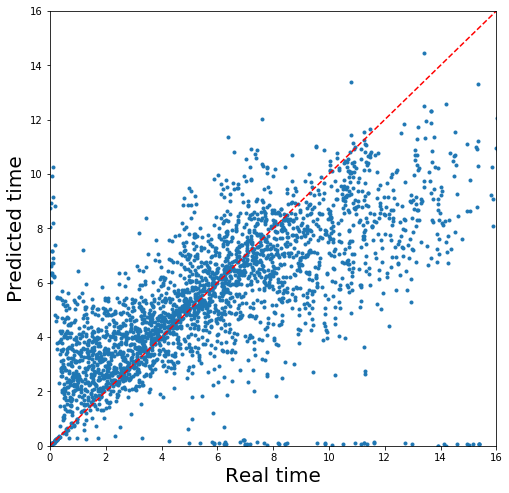

In [42]:
fig=plt.figure(figsize=(8,8))
ax=fig.add_subplot(111)
ax.plot(T_test,Estimates,'.')
ax.plot([0,16],[0,16],'r--')
ax.set_xlabel('Real time',fontsize=20)
ax.set_ylabel('Predicted time',fontsize=20)
ax.set_xlim((0,16))
ax.set_ylim((0,16))

We can see that this method leads to a good classification for small T, although those few misclassified examples results in a high error.